In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns

**Задание констант**

In [2]:
DATASET_TRAIN_PATH = 'course_project_train.csv'
DATASET_TEST_PATH = 'course_project_test.csv'
DATASET_PRED_PATH = 'predictions.csv'
TARGET = ['Credit Default']

In [3]:
df = pd.read_csv(DATASET_TRAIN_PATH)
test = pd.read_csv(DATASET_TEST_PATH)

In [4]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


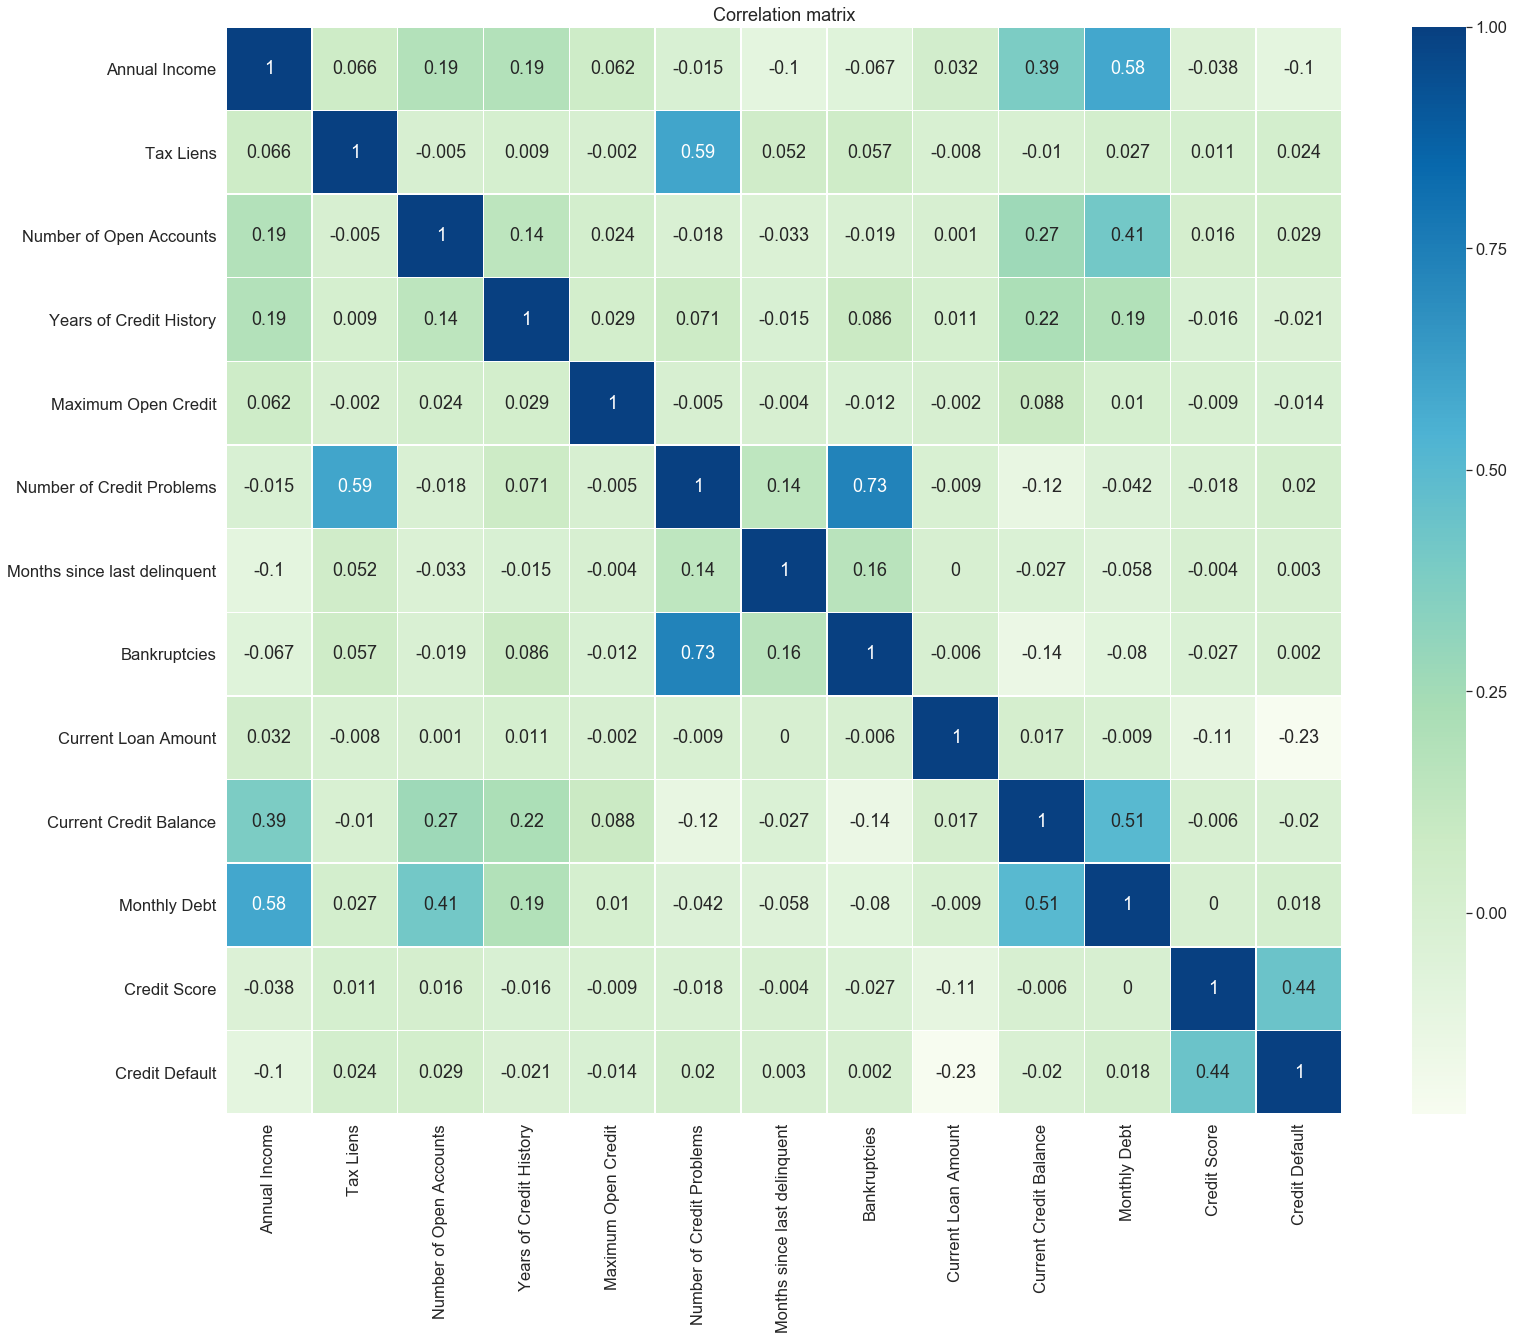

In [5]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.5)
sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Заполнение пропусков и типизация данных**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [7]:
def fillna_with_value(column, value_to_fill, df=df):
    if value_to_fill == 'median':
        df[column] = df[column].fillna(df[column].median())
    elif value_to_fill == 'mean':
        df[column] = df[column].fillna(df[column].mean())
    elif value_to_fill == 'mode':
        df[column] = df[column].fillna(df[column].mode()[0])
    elif value_to_fill == '0':
        df[column] = df[column].fillna(0)
    else:
        raise NotImplemented

Сделаем предположение, что остутствие значений в столбце ```Months since last delinquent``` равносильно отсутствию в истории данного клиента задержек по платежам.

In [8]:
fillna_with_value('Months since last delinquent', '0')
fillna_with_value('Months since last delinquent', '0', df=test)

В конечном счете, нас не так сильно интересует градация просрочек, поэтому мы можем сделать отдельный бинарный признак, где 1 – наличие просрочек.

In [9]:
dummies = []

In [10]:
def reduce_column(column, new_column, df=df, dummies=None):
    df[new_column] = df[column]
    df.loc[df[new_column] > 0, new_column] = 1
    df[new_column] = df[new_column].astype(int)
    if dummies is not None:
        dummies.append(new_column)

In [11]:
reduce_column('Months since last delinquent', 'is_delinquent', dummies=dummies)
reduce_column('Months since last delinquent', 'is_delinquent', df=test)

Тоже самое можно проделать и с арестами счетов.

In [12]:
reduce_column('Tax Liens', 'has_liens', dummies=dummies)
reduce_column('Tax Liens', 'has_liens', df=test)

Как и с банкротствами.

In [13]:
fillna_with_value('Bankruptcies', 'median')
fillna_with_value('Bankruptcies', 'median', df=test)

In [14]:
reduce_column('Bankruptcies', 'has_bankruptcies', dummies=dummies)
reduce_column('Bankruptcies', 'has_bankruptcies', df=test)

И проблемами с кредитами.

In [15]:
reduce_column('Number of Credit Problems', 'has_problems', dummies=dummies)
reduce_column('Number of Credit Problems', 'has_problems', df=test)

In [16]:
dummies

['is_delinquent', 'has_liens', 'has_bankruptcies', 'has_problems']

Заметим, что есть значения, сильно выбивающиеся из остальных.

In [17]:
def suspicious_values(column, low=.3, high=.97, df=df):
    print(f"Max value: {df[column].max()} {high}, of values: {df[column].quantile(high).round(3)}")
    print(f"Ratio: {df[column].max()/df[column].quantile(high)}")
    print(f"Min value {df[column].min()}, {low} of values {df[column].quantile(low).round(3)} ")
    print(f"Ratio: {df[column].min()/df[column].quantile(low)}")

In [18]:
def replace_suspicious_values(column, low=.3, high=.97, df=df):
    df.loc[df[column] > df[column].quantile(high), column] = df[column].median()
    df.loc[df[column] < df[column].quantile(low), column] = df[column].median()

In [19]:
suspicious_values('Annual Income')

Max value: 10149344.0 0.97, of values: 3261279.32
Ratio: 3.1120744358689323
Min value 164597.0, 0.3 of values 908568.6 
Ratio: 0.1811607841169065


In [20]:
replace_suspicious_values('Annual Income')
replace_suspicious_values('Annual Income', df=test)

In [21]:
fillna_with_value('Annual Income', 'median')
fillna_with_value('Annual Income', 'median', df=test)

По всей видимости в данном столбце ошибка: значение 400 строк в среднем в 10 раз больше всех остальных. Также, насколько мне известно, кредитный рейтинг за пределы 1000, как правило, не выходит.

In [22]:
df['Credit Score'].mean(), df['Credit Score'].median(), df['Credit Score'].quantile(.93), df['Credit Score'].quantile(.94)

(1151.0874978966851, 731.0, 751.0, 6659.599999999991)

In [23]:
df.loc[df['Credit Score'] > 900, 'Credit Score'].count()

400

In [24]:
df.loc[df['Credit Score'] > 900, 'Credit Score'].min()

6060.0

In [25]:
df.loc[df['Credit Score'] > 900, 'Credit Score'].max()

7510.0

In [26]:
df.loc[df['Credit Score'] > 900, 'Credit Score'].quantile(.10)

6650.0

Поделим значения в этих столбцах на 10.

In [27]:
df.loc[df['Credit Score'] > 900, 'Credit Score'] = df['Credit Score'] / 10

Оставшиеся пустые поля заменим медианными значениями.

In [28]:
fillna_with_value('Credit Score', 'median')
fillna_with_value('Credit Score', 'median', df=test)

In [29]:
fillna_with_value('Years in current job', 'mode')
fillna_with_value('Years in current job', 'mode', df=test)

Для удобства работы заменим название одного из значений.

In [30]:
df['Years in current job'] = df['Years in current job'].replace('< 1 year', 'lt 1 year')
test['Years in current job'] = test['Years in current job'].replace('< 1 year', 'lt 1 year')

In [31]:
numeric = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
          'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

In [32]:
suspicious_values('Number of Open Accounts')

Max value: 43.0 0.97, of values: 23.0
Ratio: 1.8695652173913044
Min value 2.0, 0.3 of values 8.0 
Ratio: 0.25


In [33]:
suspicious_values('Years of Credit History')

Max value: 57.7 0.97, of values: 34.4
Ratio: 1.677325581395349
Min value 4.0, 0.3 of values 14.3 
Ratio: 0.2797202797202797


In [34]:
suspicious_values('Maximum Open Credit')

Max value: 1304726170.0 0.97, of values: 2110383.44
Ratio: 618.2412851003041
Min value 0.0, 0.3 of values 316309.4 
Ratio: 0.0


In [35]:
replace_suspicious_values('Maximum Open Credit')
replace_suspicious_values('Maximum Open Credit', df=test)

In [36]:
suspicious_values('Current Loan Amount')

Max value: 99999999.0 0.97, of values: 99999999.0
Ratio: 1.0
Min value 11242.0, 0.3 of values 214823.4 
Ratio: 0.05233135682611857


In [37]:
df['Current Loan Amount'].median()

309573.0

In [38]:
replace_suspicious_values('Current Loan Amount')
replace_suspicious_values('Current Loan Amount', df=test)

In [39]:
suspicious_values('Current Credit Balance')

Max value: 6506797.0 0.97, of values: 942759.29
Ratio: 6.901864631851045
Min value 0.0, 0.3 of values 131373.6 
Ratio: 0.0


In [40]:
replace_suspicious_values('Current Credit Balance')
replace_suspicious_values('Current Credit Balance', df=test)

In [41]:
suspicious_values('Monthly Debt')

Max value: 136679.0 0.97, of values: 45665.66
Ratio: 2.993036780810789
Min value 0.0, 0.3 of values 11341.4 
Ratio: 0.0


In [42]:
replace_suspicious_values('Monthly Debt')
replace_suspicious_values('Monthly Debt', df=test)

**Преобразование категориальных признаков**

In [43]:
df.loc[df['Home Ownership'] == 'Home Mortgage', 'Home Ownership'] = 'Have Mortgage'
test.loc[test['Home Ownership'] == 'Home Mortgage', 'Home Ownership'] = 'Have Mortgage'

df['col1'].map(di).fillna(df['col1'])

In [44]:
purpose_map = {'small business': 'business loan', 'business loan': 'business loan', 'major purchase': 'major purchase',
              'buy a car': 'major purchase', 'medical bills': 'major purchase', 'take a trip': 'major purchase',
              'buy house': 'major purchase','wedding': 'major purchase', 'moving': 'major purchase',
              'educational expenses': 'major purchase', 'vacation': 'major purchase', 'renewable energy': 'major purchase',
              'debt consolidation': 'debt consolidation'}

In [45]:
df['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

In [46]:
df['Purpose'] = df['Purpose'].map(purpose_map).fillna('other')
test['Purpose'] = test['Purpose'].map(purpose_map).fillna('other')

Функция для создания dummy-переменных с более удобными названиями

In [47]:
def special_dummify(df, column, cat_list=None):
    for category in df[column].unique():
        col_name = f"{column.lower()}_{category.lower().replace(' ', '_')}"
        df[col_name] = df[column].map({f'{category}': 1}).fillna(0).astype(int)
        if cat_list is not None:
            cat_list.append(col_name)

In [48]:
special_dummify(df, 'Term', dummies);
special_dummify(test, 'Term');

In [49]:
dummies.remove('term_short_term')

In [50]:
df.Purpose.unique()

array(['debt consolidation', 'other', 'major purchase', 'business loan'],
      dtype=object)

In [51]:
special_dummify(df, 'Purpose', dummies);
special_dummify(test, 'Purpose');

In [52]:
df['Home Ownership'].unique()

array(['Own Home', 'Have Mortgage', 'Rent'], dtype=object)

In [53]:
special_dummify(df, 'Home Ownership', dummies);
special_dummify(test, 'Home Ownership');

In [54]:
special_dummify(df, 'Years in current job', dummies)
special_dummify(test, 'Years in current job')

**Корреляция с целевым признаком**

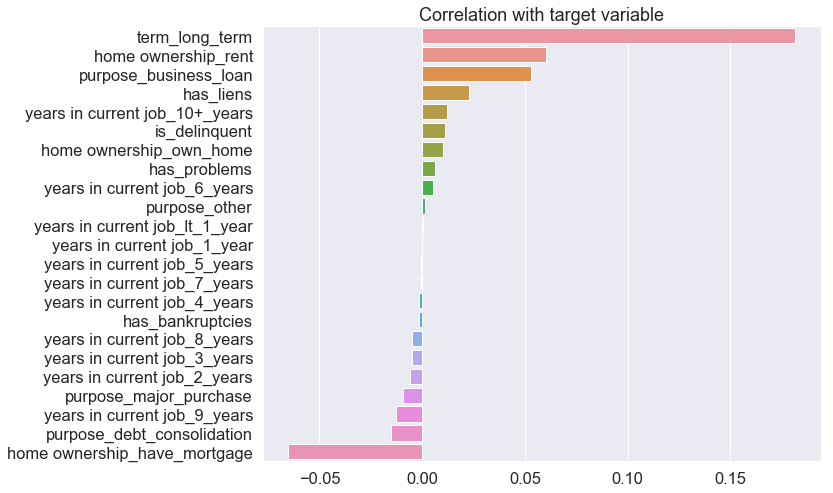

In [55]:
corr_with_target = df[dummies + TARGET].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [56]:
dummies.remove('years in current job_lt_1_year')
dummies.remove('years in current job_1_year')
dummies.remove('years in current job_5_years')
dummies.remove('years in current job_7_years')

In [57]:
cbClassifier = cb.CatBoostClassifier(iterations=50,
                                     learning_rate=1,
                                     depth=13,
                                     silent=True)

In [58]:
X = df[numeric + dummies]
y = df[TARGET]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)

In [60]:
cbClassifier.fit(X_train, y_train)

In [61]:
y_pred = cbClassifier.predict(X_test)

In [62]:
f1_score(y_test, y_pred)

0.34724857685009486

In [63]:
test.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'is_delinquent', 'has_liens', 'has_bankruptcies',
       'has_problems', 'term_short_term', 'term_long_term',
       'purpose_debt_consolidation', 'purpose_major_purchase', 'purpose_other',
       'purpose_business_loan', 'home ownership_rent',
       'home ownership_have_mortgage', 'home ownership_own_home',
       'years in current job_4_years', 'years in current job_1_year',
       'years in current job_3_years', 'years in current job_10+_years',
       'years in current job_6_years', 'years in current job_5_years',
       'years in current job_lt_1_year', 'years in current job_2_years',
       'years in current job_9_yea

In [64]:
to_pred = test[numeric + dummies]

In [65]:
test_pred = cbClassifier.predict(to_pred)

In [67]:
test['Credit Default'] = test_pred

In [68]:
test.index.rename('id', inplace=True)

In [69]:
test['Credit Default'].to_csv(DATASET_PRED_PATH, header=True)